In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from scipy import stats 
import statsmodels.api as sm
import random

In [2]:
df = pd.read_csv('data.csv', sep=',', header=0, index_col=None)
df.head(5)

,personid,anchor,var3,judgement,random,questionid,trueanswer
0,1,51,H,48,-3,1,30.5
1,2,51,H,48,-3,1,30.5
2,3,10,L,-28,-38,1,30.5
3,4,10,L,0,-10,1,30.5
4,1,27,L,3,-24,2,65.0


In [3]:
#Bootstrapping

n = 500
sampleH = df[df['var3']=='H']
sampleL = df[df['var3']=='L']

def sampling(sample, n):
    newSample = np.random.choice(sample.personid, n, replace = True)
    data = sample.copy()

    for i in range(n):
        sampled = sample[sample['personid'] == newSample[i]].sample()
        data = data.append(sampled)
        
    return data

#Concatenating new samples with the original data 
dataH = sampling(sampleH, n)
dataL = sampling(sampleL, n)
data = pd.concat([df, dataH, dataL])

# Reseting indexes of final data
data = data.reset_index(drop=True)

In [4]:
data.tail(5)

,personid,anchor,var3,judgement,random,questionid,trueanswer
1187,4,221,L,241,20,15,356.5
1188,1,13,L,52,39,16,34.0
1189,1,138,L,142,4,22,184.5
1190,1,84,L,95,11,18,130.5
1191,1,66,L,82,16,8,77.5


In [5]:
# Deviation of judgement from trueanswer
data['deviation1'] = data['judgement'] - data['trueanswer']

# Deviation of anchor from trueanswer
data['deviation2'] = data['anchor'] - data['trueanswer']

# Binary anchor 
data['anchor_binary'] = np.where(data['var3']=='H', 1, 0)

# Binary Deviation of judgement from trueanswer
data['deviation_binary'] = np.where((data['judgement'] - data['trueanswer']) > 0, 1, 0)

data.head(5)

,personid,anchor,var3,judgement,random,questionid,trueanswer,deviation1,deviation2,anchor_binary,deviation_binary
0,1,51,H,48,-3,1,30.5,17.5,20.5,1,1
1,2,51,H,48,-3,1,30.5,17.5,20.5,1,1
2,3,10,L,-28,-38,1,30.5,-58.5,-20.5,0,0
3,4,10,L,0,-10,1,30.5,-30.5,-20.5,0,0
4,1,27,L,3,-24,2,65.0,-62.0,-38.0,0,0


In [6]:
#Descriptive statistics that summarize the central tendency and dispersion

data[['anchor', 'judgement', 'trueanswer', 'deviation1', 'deviation2']].describe().round(0).astype(int)

,anchor,judgement,trueanswer,deviation1,deviation2
count,1192,1192,1192,1192,1192
mean,191,192,193,-1,-2
std,181,186,163,92,85
min,10,-28,24,-218,-170
25%,66,68,76,-44,-38
50%,123,135,132,-4,0
75%,231,270,356,49,38
max,700,738,530,208,170


In [7]:
#Grouping the data by anchor (High/Low), ignoring personid, questionid, random

byanchor = data.groupby(['var3']).mean()
byanchor.drop(['personid','questionid','random'], axis=1, inplace=True)
byanchor.round(0).astype(int)

,anchor,judgement,trueanswer,deviation1,deviation2,anchor_binary,deviation_binary
var3,,,,,,,
H,246,247,187,61,60,1,1
L,135,136,198,-63,-63,0,0


In [8]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


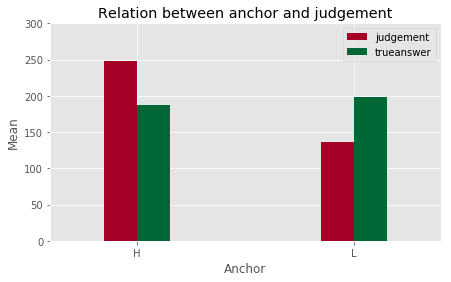

In [9]:
#Bar plot by anchor

style.use('ggplot')
judge_anchor = byanchor[['judgement','trueanswer']]
ax = judge_anchor.plot(subplots=False, figsize=(7, 4), kind='bar', width=0.3, colormap='RdYlGn', title ="Relation between anchor and judgement")
ax.set_xlabel("Anchor")
ax.set_ylabel("Mean")
plt.xticks(rotation=360)
plt.ylim([0,300]);

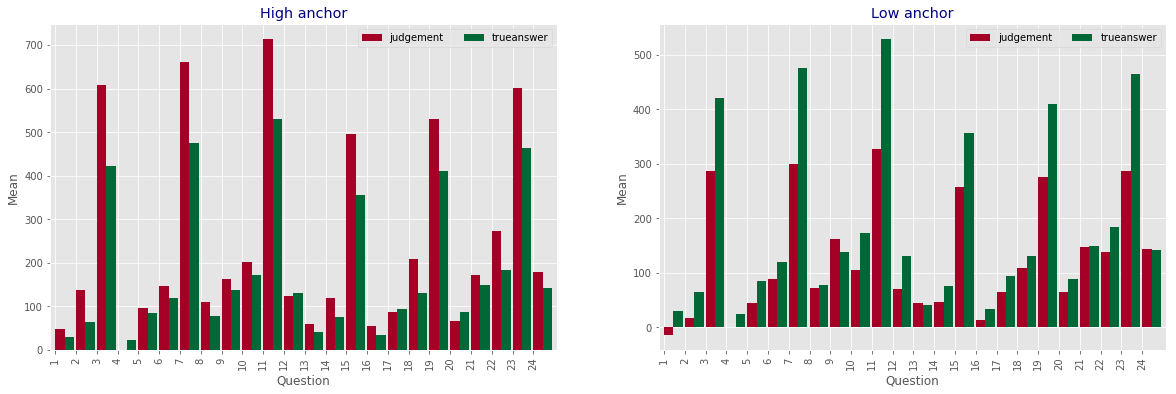

In [10]:
# Grouping by High/Low anchor

mask1 = data['var3'] == 'H'
mask2 = data['var3'] == 'L'

H = data[mask1][['judgement','trueanswer','questionid']]
L = data[mask2][['judgement','trueanswer','questionid']]

colors=['#A50026','#006837']

High = H.groupby(['questionid']).mean()
Low = L.groupby(['questionid']).mean()

# Bar plots for questions by anchor (High/Low)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
High.plot(ax=axes[0], kind='bar', width=0.9, color=colors,align='edge')
axes[0].set_title("High anchor", color='navy')
Low.plot(ax=axes[1], kind='bar', width=0.9, color=colors,align='edge')
axes[1].set_title("Low anchor", color='navy')

for ax in axes:
    ax.set_xlabel('Question')
    ax.set_ylabel('Mean')
    ax.legend(loc='best', ncol=2)
plt.show();

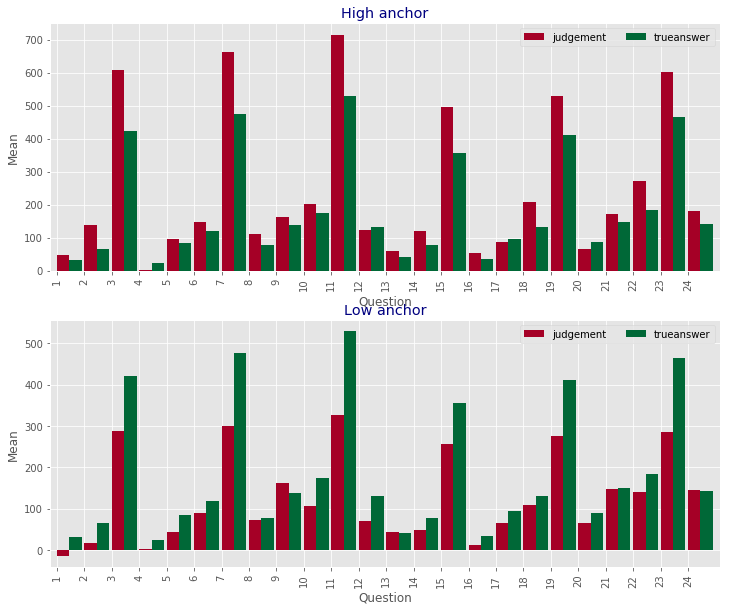

In [11]:
#Same plots but bigger

colors=['#A50026','#006837']
fig, axes = plt.subplots(nrows=2, ncols=1)
High.plot(ax=axes[0],kind='bar',width=0.9,color=colors,align='edge',figsize=(12, 10))
axes[0].set_title("High anchor", color='navy')
Low.plot(ax=axes[1],kind='bar', width=0.9,color=colors,align='edge',figsize=(12, 10))
axes[1].set_title("Low anchor", color='navy')

for ax in axes:
    ax.set_xlabel('Question')
    ax.set_ylabel('Mean')
    ax.legend(loc='best', ncol=2)
plt.show();

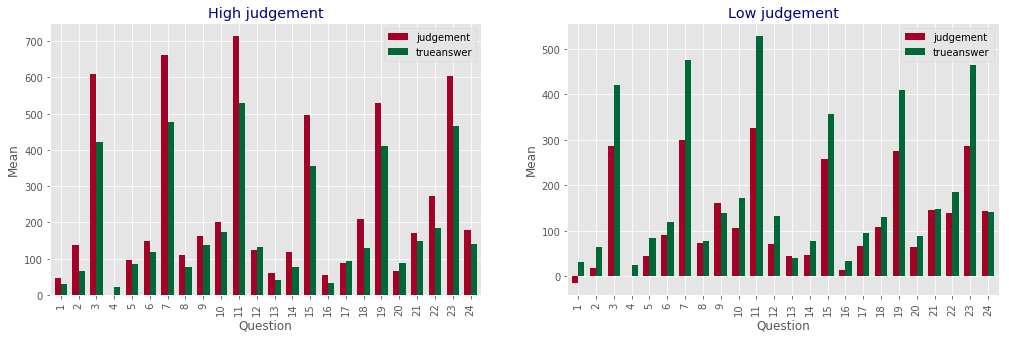

In [12]:
# Grouping questions by High/Low judgement

judgeH = data[mask1][['judgement','trueanswer','questionid']]
judgeL = data[mask2][['judgement','trueanswer','questionid']]

judge_H = judgeH.groupby(['questionid']).mean()
judge_L = judgeL.groupby(['questionid']).mean()

# Second version of bar plots by questions for High/Low judgement

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
judge_H.plot(ax=axes[0], kind='bar', width=0.7, colormap='RdYlGn')
axes[0].set_title("High judgement", color='navy')
judge_L.plot(ax=axes[1], kind='bar', width=0.7, colormap='RdYlGn')
axes[1].set_title("Low judgement", color='navy')

for ax in axes:
    ax.set_xlabel('Question')
    ax.set_ylabel('Mean')
    ax.legend(loc='upper right')
plt.show();

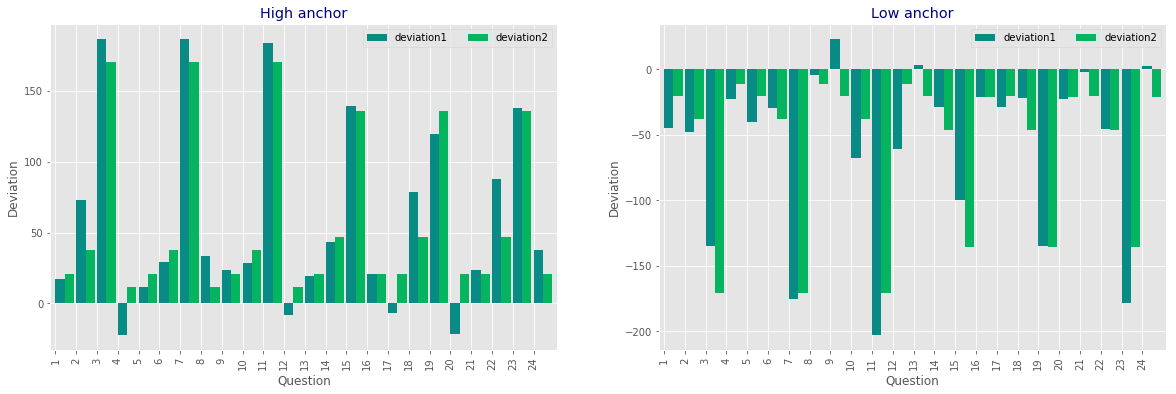

In [13]:
# Grouping by High/Low anchor

mask1 = data['var3'] == 'H'
mask2 = data['var3'] == 'L'

H = data[mask1][['deviation1','deviation2','questionid']]
L = data[mask2][['deviation1','deviation2','questionid']]

colors=['#088A85','#04B45F']

High = H.groupby(['questionid']).mean()
Low = L.groupby(['questionid']).mean()

# Bar plots of deviations by questions for High/Low anchor

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
High.plot(ax=axes[0], kind='bar', width=0.9, color=colors,align='edge')
axes[0].set_title("High anchor", color='navy')
Low.plot(ax=axes[1], kind='bar', width=0.9, color=colors,align='edge')
axes[1].set_title("Low anchor", color='navy')

for ax in axes:
    ax.set_xlabel('Question')
    ax.set_ylabel('Deviation')
    ax.legend(loc='best', ncol=2)
plt.show();

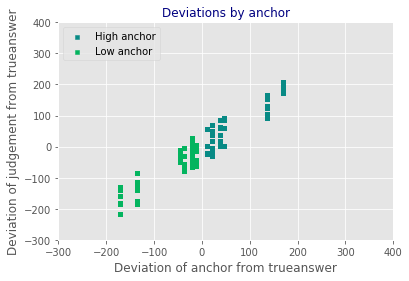

In [14]:
# Scatter plot between deviations by anchors

H = data[data['var3'] == 'H'][['deviation1','deviation2']]
L = data[data['var3'] == 'L'][['deviation1','deviation2']]

plt.scatter(H['deviation2'], H['deviation1'], facecolor='#088A85', s=20, label="High anchor",marker="s")
plt.scatter(L['deviation2'], L['deviation1'], facecolor='#04B45F', s=20, label="Low anchor",  marker="s")
plt.legend(loc='upper left');
plt.ylabel('Deviation of judgement from trueanswer')
plt.xlabel('Deviation of anchor from trueanswer')
plt.title('Deviations by anchor', fontsize=12, color='navy')
plt.xlim([-300,400])
plt.ylim([-300,400]);

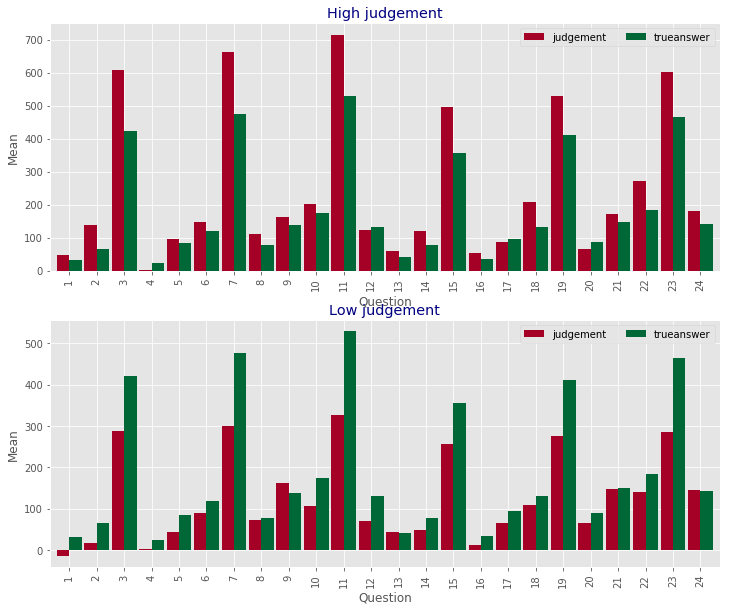

In [15]:
#Same plots but bigger

fig, axes = plt.subplots(nrows=2, ncols=1)
judge_H.plot(ax=axes[0],kind='bar',width=0.9,colormap='RdYlGn',align='center',figsize=(12, 10))
axes[0].set_title("High judgement", color='navy')
judge_L.plot(ax=axes[1],kind='bar', width=0.9,colormap='RdYlGn',align='center',figsize=(12, 10))
axes[1].set_title("Low judgement", color='navy')

for ax in axes:
    ax.set_xlabel('Question')
    ax.set_ylabel('Mean')
    ax.legend(loc='upper right', ncol=2)
plt.show();

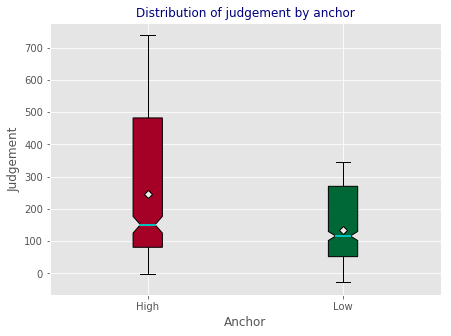

In [16]:
#Box plot by anchor

judgeH = data[mask1]['judgement']
judgeL = data[mask2]['judgement']
data2 = [judgeH, judgeL]

colors=['#A50026','#006837']
labels = ['High', 'Low']

median = dict(linestyle='-', linewidth=2, color='c')
meanp = dict(marker='D', markeredgecolor='black', markerfacecolor='#EDECE9')
plt.subplots(figsize=(7,5))

box = plt.boxplot(data2, labels=labels, notch=True, patch_artist=True, medianprops=median, showmeans=True, meanprops=meanp)

for patch, color in zip(box['boxes'], colors):
     patch.set_facecolor(color)

plt.title('Distribution of judgement by anchor', fontsize=12, color='navy')
plt.xlabel('Anchor')
plt.ylabel('Judgement');

In [17]:
# How well the anchor explained the deviation of judgement from trueanswer?

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


X, y = np.array(data['deviation1']).reshape(len(data['deviation1']), -1), np.array(data['anchor_binary'])

# Splitting the data before trainning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


model = LogisticRegression(C=1e5).fit(X_train, y_train)
pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.0f}%'.format(model.score(X_test, y_test) * 100))

C:\Users\adric\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy of logistic regression classifier on test set: 83%


In [18]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.85      0.83      0.84       126
          1       0.81      0.83      0.82       113

avg / total       0.83      0.83      0.83       239



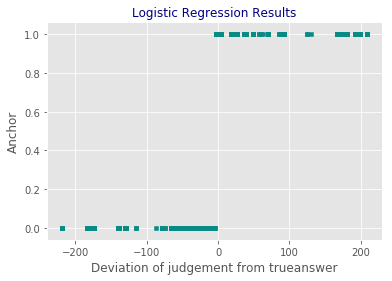

In [19]:
# Results on test set

plt.scatter(X_test, pred, facecolor='#088A85', s=20, marker="s")
plt.xlabel('Deviation of judgement from trueanswer')
plt.ylabel('Anchor')
plt.title('Logistic Regression Results', fontsize=12, color='navy');